El modelo ARIMA (Autoregressive Integrated Moving Average) y su versión automatizada, conocida como Auto-ARIMA, son herramientas fundamentales en el análisis y la predicción de series temporales. ARIMA es un modelo que combina componentes autoregresivos, de promedio móvil y de diferenciación para modelar y prever patrones en series temporales. Auto-ARIMA, por otro lado, es una variante que busca automáticamente los mejores hiperparámetros para un modelo ARIMA, lo que lo convierte en una opción valiosa para aquellos que desean un enfoque más simplificado y eficiente en la selección del modelo.


*The ARIMA (Autoregressive Integrated Moving Average) model and its automated version, known as Auto-ARIMA, are fundamental tools in the analysis and prediction of time series data. ARIMA is a model that combines autoregressive, moving average, and differencing components to model and forecast patterns in time series data. Auto-ARIMA, on the other hand, is a variant that automatically searches for the best hyperparameters for an ARIMA model, making it a valuable choice for those seeking a more streamlined and efficient approach to model selection.*

## Arima

Un modelo ARIMA se caracteriza por 3 términos: p, d, q

dónde,

p: es el orden del término AR

q: es el orden del término MA

d: es el número de diferenciaciones necesarias para que la serie de tiempo sea estacionaria

Si una serie de tiempo tiene patrones estacionales, entonces debemos agregar términos estacionales a nuestro modelo; esto lo convierte en SARIMA, abreviatura de "Seasonal ARIMA".

Intentaremos crear primero nuestro modelo Arima de forma "manual", es decir, buscando y ajustando los hiperparámetros en un entorno de experimentación. Luego compararemos nuestros resultados con el modelo automatizado.



*An ARIMA model is characterized by 3 terms: p, d, q*

*Where,*

*p: is the order of the AR term*

*q: is the order of the MA term*

*d: is the number of differencings required to make the time series stationary*

*If a time series exhibits seasonal patterns, then we need to add seasonal terms to our model, which turns it into SARIMA, an abbreviation for "Seasonal ARIMA."*

*We will first attempt to create our ARIMA model manually, meaning we will search for and adjust the hyperparameters in an experimental environment. Then, we will compare our results with the automated model.*

##Carga de datos y librerias/ *Loading data and libraries*

In [4]:
# Import libraries
import random
import os
import numpy as np
import pandas as pd
import requests

# Date
import datetime as dt
from datetime import date, timedelta, datetime
import time

# EDA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Time Series - EDA and Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Modeling and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('df_BTC_withTransformations.csv',
            index_col = "date",
            parse_dates = True).asfreq("D")

In [6]:
df.tail(5)

,original_series,diff,sqrt,inverse,log,squared,cubic,boxcox,yeo-johnson
date,,,,,,,,,
2023-09-05,25722.4,51.9,160.382044,0.000039,10.155117,6.616419e+08,29.519149,1.189321,1.191613
2023-09-06,25709.9,-12.5,160.343070,0.000039,10.154631,6.609990e+08,29.514366,1.189076,1.191373
2023-09-07,26146.7,436.8,161.699412,0.000038,10.171478,6.836499e+08,29.680574,1.197583,1.199672
2023-09-08,25890.6,-256.1,160.905562,0.000039,10.161635,6.703232e+08,29.583351,1.192610,1.194821
2023-09-09,25883.5,-7.1,160.883498,0.000039,10.161361,6.699556e+08,29.580647,1.192472,1.194686


Trabajaremos en principio con la versión logarítmica de la serie.

*We will work initially with the logarithmic version of the series.*

## Orden de diferenciación (d)/ Order of differencing (d)

El propósito de la diferenciación es lograr la estacionariedad en la serie temporal.

Sin embargo, es importante tener cuidado de no aplicar demasiadas diferenciaciones a la serie, ya que un exceso de diferenciación puede mantener la serie estacionaria pero afectar negativamente los parámetros del modelo.

Entonces, ¿cómo determinar el orden de diferenciación adecuado?

El orden de diferenciación adecuado es el mínimo necesario para obtener una serie casi estacionaria que fluctúe alrededor de una media definida y cuya función de autocorrelación (ACF) converja rápidamente a cero.

Si las autocorrelaciones son predominantemente positivas para muchos rezagos (10 o más), entonces la serie puede requerir una mayor diferenciación. Por otro lado, si la autocorrelación en el primer rezago es muy negativa, es posible que la serie esté sobre-diferenciada.

En caso de que no pueda decidir entre dos órdenes de diferenciación, elija el orden que resulte en una desviación estándar más baja en la serie diferenciada.

*The purpose of differencing is to achieve stationarity in the time series.*

*However, it is important to be cautious about over-differencing the series because excessive differencing can maintain stationarity but adversely affect the model's parameters.*

*So, how do we determine the appropriate order of differencing?*

*The correct order of differencing is the minimum required to obtain a nearly stationary series that fluctuates around a defined mean, and its Autocorrelation Function (ACF) quickly converges to zero.*

*If autocorrelations are mostly positive for many lags (10 or more), then the series may need further differencing. Conversely, if the autocorrelation at lag 1 is overly negative, the series may be over-differenced.*

*In the event you cannot decide between two orders of differencing, opt for the order that results in the lowest standard deviation in the differenced series.*

En nuestro capitulo 2 hemos realizado la prueba de D. Fuller sobre la serie logarítmica y concluimos que la serie es estacionaria, por lo tanto, para este caso, podemos decir que d=0.

*In our Chapter 2, we conducted the Dickey-Fuller test on the logarithmic series and concluded that the series is stationary. Therefore, for this case, we can say that d=0.*

## Orden del término AR (p)/ *Order of the AR term (p)*

El siguiente paso consiste en identificar si el modelo requiere algún término autoregresivo (AR). Podemos determinar la cantidad necesaria de términos AR al examinar el gráfico de Autocorrelación Parcial (PACF). ¿Cómo encontramos el número de términos AR?

Cualquier autocorrelación en una serie estacionaria se puede corregir mediante la adición de suficientes términos AR. Por lo tanto, inicialmente, tomamos el orden del término AR como igual al número de rezagos que cruzan el límite de significancia en el gráfico PACF.


*The next step is to identify if the model requires any autoregressive (AR) terms. We can determine the necessary number of AR terms by examining the Partial Autocorrelation Function (PACF) plot. How do we find the number of AR terms?*

*Any autocorrelation in a stationary series can be rectified by adding enough AR terms. Therefore, initially, we take the order of the AR term to be equal to the number of lags that cross the significance boundary in the PACF plot.*

In [7]:
def PACF(df, column):
  pacf_values = sm.tsa.pacf(df, nlags=20, method='ols')
  plt.figure(figsize=(12, 6))
  plot_pacf(df, lags=20)
  plt.xlabel('Lag')
  plt.ylabel('Autocorrelation coefficient')
  plt.title(f'Partial autocorrelation of column: "{column}"')
  plt.show()

<Figure size 1200x600 with 0 Axes>

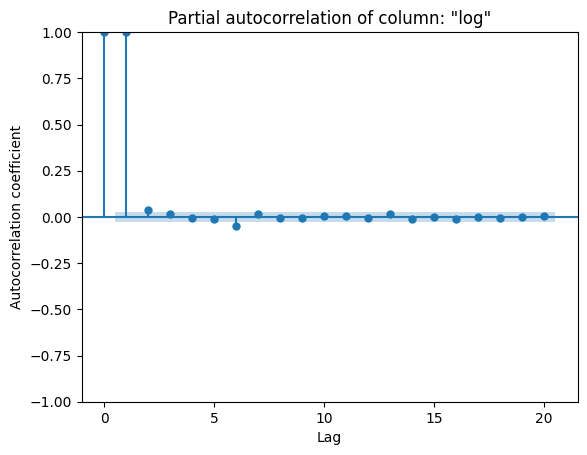

In [8]:
PACF(df['log'], 'log')

Ajustaremos el término AR en 1.

*We will set the AR term to 1.*


## Orden del término MA (q)/ *Order of the MA term (q)*

De manera similar a cómo observamos el gráfico de PACF para determinar el número de términos AR, podemos examinar el gráfico de ACF para el número de términos MA. Un término MA representa técnicamente el error de pronóstico retrasado.

El ACF nos indica cuántos términos MA se necesitan para eliminar cualquier autocorrelación en la serie estacionaria.

Echemos un vistazo al gráfico de autocorrelación.

Vemos que un par de rezagos están significativamente por encima de la línea de importancia. Por lo tanto, podemos establecer tentativamente q en 1. En caso de duda, es preferible optar por el modelo más simple que explique adecuadamente la variable Y.




*In the same way that we observe the PACF plot for the number of AR terms, we can examine the ACF plot for the number of MA terms. A MA term technically represents the lagged forecast error.*

*The ACF plot indicates how many MA terms are needed to eliminate any autocorrelation in the stationary series.*

*Let's take a look at the autocorrelation plot.*

*We see that a couple of lags are significantly above the significance line. Therefore, we can tentatively set q to 1. When in doubt, it's preferable to choose the simpler model that adequately explains the variable Y.*

## Arima (1,0,1)

Crearemos entonces un modelo sin diferenciación, con un término AR de 1 y un término MA de 1.

*We will then create a model without differencing, with an AR term of 1, and an MA term of 1.*

In [9]:
dfLog = df[['log']]
trainLog = dfLog.loc[dfLog.index < '2023-01-01']
testLog = dfLog.loc[dfLog.index >= '2023-01-01']

In [10]:
trainLog.shape

(4551, 1)

In [11]:
testLog.shape

(252, 1)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# 1,0,1 ARIMA Model
model1 = ARIMA(trainLog, order=(1,0,1))
model_fit1 = model1.fit()
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                 4551
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6335.219
Date:                Wed, 11 Oct 2023   AIC                         -12662.437
Time:                        19:02:53   BIC                         -12636.745
Sample:                    07-17-2010   HQIC                        -12653.389
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6565      5.646      0.648      0.517      -7.410      14.723
ar.L1          0.9999      0.000   4070.749      0.000       0.999       1.000
ma.L1          0.0401      0.007      5.862      0.000       0.027       0.054
sigma2         0.0036    1.1e-05    328.336      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):           2189381.66
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       110.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lo primero que debemos mirar son los coeficientes de nuestros parámetros; si el número del coeficiente esta cercano a 0 significa que ese parametro especifico tiene poca relevancia en nuestro modelo.
Otro punto que debemos atender es el valor 	P>|z|, este debe ser cercano a 0 para que esos parámetros sean relevantes para nuestro modelo.

*The first thing we should look at is the coefficients of our parameters. If the coefficient's value is close to 0, it means that specific parameter has little relevance in our model. Another point to consider is the value P>|z|, which should be close to 0 for those parameters to be relevant in our model.*

### Explicación de los resultados/ *Explication of the results*

Log Likelihood (Verosimilitud en Logaritmos):

  Objetivo: Medir cuán bien se ajusta el modelo a los datos observados. Un valor más alto es mejor.

  Valor en nuestro modelo: El valor es 6335.219, que es bastante alto, lo que sugiere que el modelo se ajusta bien a los datos observados. Esto es positivo.

Criterios de Información (AIC, BIC, HQIC):

  Objetivo: Proporcionar criterios para comparar diferentes modelos. Valores más bajos indican un mejor ajuste.

  Valor en nuestro modelo: En tu modelo, los valores son AIC = -12662.437, BIC = -12636.745 y HQIC = -12653.389. Estos valores son deseados ya que son bajos y sugieren un buen ajuste del modelo.

Sigma2:

  Objetivo: Representa la varianza del error. Cuanto menor sea este valor, mejor.

  Valor en nuestro modelo: Sigma2 es 0.0036, que es un valor bajo. Esto sugiere una baja varianza del error, lo cual es positivo.

*Log Likelihood (Logarithmic Likelihood):*

*Objective: Measure how well the model fits the observed data. A higher value is better.*

*Value in our model: The value is 6335.219, which is quite high, suggesting that the model fits the observed data well. This is positive.*

*Information Criteria (AIC, BIC, HQIC):*

*Objective: Provide criteria for comparing different models. Lower values indicate a better fit.*

*Value in our model: In your model, the values are AIC = -12662.437, BIC = -12636.745, and HQIC = -12653.389. These values are desirable as they are low and suggest a good model fit.*

*Sigma2:*

*Objective: Represents the error variance. A lower value is better.*

*Value in our model: Sigma2 is 0.0036, which is a low value. This suggests low error variance, which is positive.*

### Residuos/ *Residuals*

En base a estas pruebas, nuestro modelo parece tener problemas significativos, especialmente en términos de distribución no normal de los residuos y heteroscedasticidad. Ahondemos en este punto, para intentar mejorar esas variables:

*Based on these tests, our model appears to have significant issues, especially in terms of non-normal distribution of residuals and heteroscedasticity. Let's delve deeper into this point to try and improve these variables.*


1. **Ljung-Box (Q):**
   - Objetivo: Queremos que los residuos no estén autocorrelacionados, lo que significa que no deben mostrar patrones sistemáticos en su autocorrelación.
   - Valor Óptimo: El valor Q debe ser bajo o cercano a cero.
   - Valor en nuestro modelo: El valor Q es 0.56, lo que sugiere que los residuos no están autocorrelacionados de manera significativa. Esto es positivo.

2. **Jarque-Bera (JB):**
   - Objetivo: Queremos que los residuos sigan una distribución normal. Un valor alto indica que los residuos no siguen una distribución normal.
   - Valor Óptimo: El valor JB debe ser bajo.
   - Valor en nuestro modelo: El valor JB es extremadamente alto (2189381.66).  Este es un problema importante y sugiere que los residuos tienen una distribución no normal.

3. **Heteroskedasticity (H):**
   - Objetivo: Queremos que los residuos tengan una varianza constante a lo largo del tiempo. Un valor bajo indica que los residuos tienen una varianza constante.
   - Valor Óptimo: El valor H debe ser bajo.
  - Valor en nuestro modelo: El valor H es 0.18, lo que sugiere que los residuos no tienen una varianza constante. Esto es un problema y sugiere que la varianza de los residuos cambia a lo largo del tiempo.

  



*1. Ljung-Box (Q):*

*-Objective: We want the residuals to be uncorrelated, meaning they should not exhibit systematic patterns in their autocorrelation.*

*-Optimal Value: The Q value should be low or close to zero.*

*-Value in Our Model: The Q value is 0.56, suggesting that the residuals are not significantly autocorrelated. This is positive.*

*2. Jarque-Bera (JB):*

*-Objective: We want the residuals to follow a normal distribution. A high value indicates that the residuals do not follow a normal distribution.*

*-Optimal Value: The JB value should be low.*

*-Value in Our Model: The JB value is extremely high (2189381.66). This is a significant issue and suggests that the residuals do not have a normal distribution.*

*3. Heteroskedasticity (H):*

*-Objective: We want the residuals to have constant variance over time. A low value indicates that the residuals have constant variance.*

*-Optimal Value: The H value should be low.*

*-Value in Our Model: The H value is 0.18, suggesting that the residuals do not have constant variance. This is a problem and suggests that the variance of the residuals changes over time.*



<Axes: xlabel='date'>

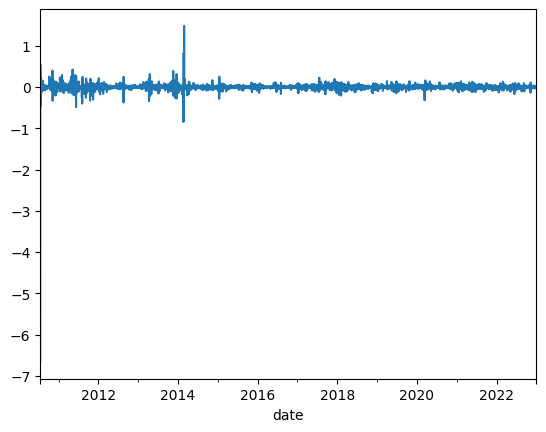

In [13]:
resid = model_fit1.resid
resid.plot()

<Axes: ylabel='Density'>

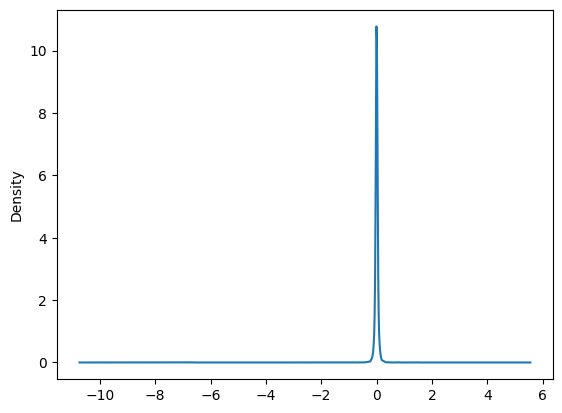

In [14]:
resid.plot(kind='kde')

In [15]:
# summary stats of residuals
print(resid.describe())

count    4551.000000
mean        0.001371
std         0.115597
min        -6.662054
25%        -0.013851
50%         0.001476
75%         0.020630
max         1.483466
dtype: float64


La media cercana a cero es una señal positiva, ya que indica que el modelo no tiene un sesgo sistemático en sus predicciones.

La desviación estándar debe ser lo más baja posible, indicando residuos con poca dispersión alrededor de la media.

El rango de valores de los residuos es bastante amplio, con un valor mínimo de -6.662054 y un valor máximo de 1.483466. Esto nos confirma que existen valores atípicos y que los residuos no siguen una distribución normal.



*A mean close to zero is a positive signal as it indicates that the model does not have systematic bias in its predictions.*

*The standard deviation should be as low as possible, indicating residuals with little dispersion around the mean.*

*The range of residual values is quite wide, with a minimum value of -6.662054 and a maximum value of 1.483466. This confirms the presence of outliers and suggests that the residuals do not follow a normal distribution.*

## Shapiro-Wilk Test

Haremos el Test de normalidad de Shapiro para analizar los residuos y confirmar nuestra suposición. Si el valor p es mayor que 0.05 (el nivel de significancia), se acepta la hipótesis nula de normalidad.

*We will perform the Shapiro-Wilk normality test to analyze the residuals and confirm our assumption. If the p-value is less than 0.05 (the significance level) we accept the H0.*

In [26]:

statistic, p_value = stats.shapiro(resid)

print("Statistic Test:", statistic)
print("p value:", p_value)


alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data appears to follow a normal distribution (H0 not rejected)")
else:
    print("The data does not follow a normal distribution (H0 rejected)")

Statistic Test: 0.23146647214889526
p value: 0.0
The data does not follow a normal distribution (H0 rejected)


## Auto-Arima

Pudimos ver que nuestro modelo ARIMA creado manualmente, a partir de indagar las funciones de autocorrelación, nos dió un resultado con una distribución no-normal de residuos.
Buscaremos los mejores parametros ahora utilizando la versión automática del modelo Arima.

*We observed that our manually created ARIMA model, based on investigating autocorrelation functions, yielded a result with non-normal distribution of residuals. We will now search for the best parameters using the automated version of the Arima model.*

In [16]:
!pip install pmdarima

In [17]:
from pmdarima import auto_arima

In [18]:
model = auto_arima(y = trainLog, seasonal=False, d=1,
                      start_p=1, start_q=1, max_order=5, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)
print('modelo Auto Arima entrenando...(esto puede tomar algunos minutos)')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12708.516, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12677.619, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12678.645, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12679.973, Time=3.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12669.773, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12780.388, Time=6.93 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12782.292, Time=1.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12780.501, Time=2.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12778.415, Time=9.82 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-12771.739, Time=0.97 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 28.952 seconds
modelo Auto Arima entrenando...(esto puede tomar algunos minutos)


In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4551
Model:               SARIMAX(2, 1, 0)   Log Likelihood                6395.146
Date:                Wed, 11 Oct 2023   AIC                         -12782.292
Time:                        19:04:55   BIC                         -12756.600
Sample:                    07-17-2010   HQIC                        -12773.244
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031      0.001      3.375      0.001       0.001       0.005
ar.L1          0.0300      0.007      4.402      0.000       0.017       0.043
ar.L2         -0.1526      0.005    -33.189      0.000      -0.162      -0.144
sigma2         0.0035   1.63e-05    216.181      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1473949.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
predictions = pd.Series(model.predict(n_periods=len(testLog)))

In [23]:
MAPE = mean_absolute_percentage_error(testLog['log'], predictions)
print(f'The MAPE is : {MAPE}')

The MAPE is : 0.014812412542870692


In [ ]:
df['close'] = np.exp(df['log_close'])

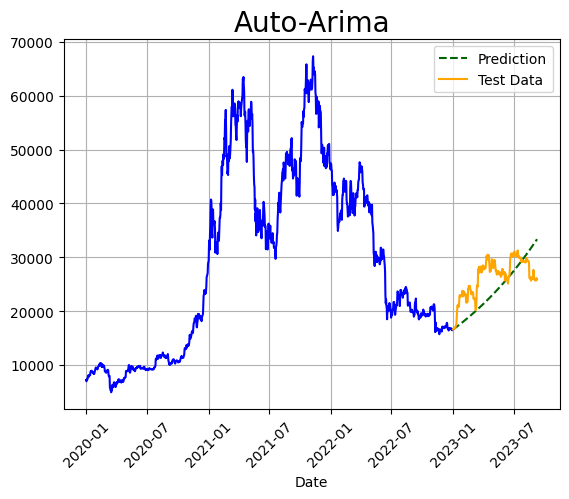

In [28]:
#Visualize the prediction with original values
import datetime
start_date = datetime.datetime(2020, 1, 1)

fig, ax = plt.subplots()
ax.plot(np.exp(trainLog[start_date:]), color="blue")


ax.plot(
        np.exp(predictions),
        color="darkgreen",
        ls="--", label='Prediction')

ax.plot(np.exp(testLog), color = "orange", label='Test Data')
# Más personalización de la gráfica
ax = plt.gca()
ax.tick_params(axis="x", labelrotation = 45)
ax.set_title('Auto-Arima', fontsize = 20)
ax.set_xlabel("Date")
ax.grid()
ax.legend()
plt.show()

## Conclusión/ Conclusion

Si bien con este último modelo logramos predecir, por lo menos, la direccion del movimiento, está claro que un modelo autoregresivo como el modelo ARIMA no es el más indicado para predecir un activo tan volátil como Bitcoin.
La imprevisibilidad de los factores exógenos, el comportamiento no estacionario y la volatilidad extrema de los mercados financieros lleva a modelos con un nivel de error alto. En los siguiente capitulos exploraremos otros modelos, en el afán de conseguir resultados promisorios.

*While with this latest model, we managed to predict, at least, the direction of movement, it is clear that an autoregressive model like the ARIMA model is not the most suitable for predicting such a volatile asset as Bitcoin.*

*The unpredictability of exogenous factors, non-stationary behavior, and extreme market volatility result in models with a high level of error. In the following chapters, we will explore other models in the quest for promising results.*